In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import os.path as osp
import numpy as np
%matplotlib inline

In [36]:
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [37]:
DIV_LINE_WIDTH = 50

# Global vars for tracking and labeling data at load time.
exp_idx = 0
units = dict()

In [38]:
def plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs):
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[value])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            datum[value] = smoothed_x

    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
    sns.set(style="darkgrid", font_scale=1.5)
    sns.tsplot(data=data, time=xaxis, value=value, unit="Unit", condition=condition, ci='sd', **kwargs)
    """
    If you upgrade to any version of Seaborn greater than 0.8.1, switch from 
    tsplot to lineplot replacing L29 with:

        sns.lineplot(data=data, x=xaxis, y=value, hue=condition, ci='sd', **kwargs)

    Changes the colorscheme and the default legend style, though.
    """
    plt.legend(loc='best').set_draggable(True)
    #plt.legend(loc='upper center', ncol=3, handlelength=1,
    #           borderaxespad=0., prop={'size': 13})

    """
    For the version of the legend used in the Spinning Up benchmarking page, 
    swap L38 with:

    plt.legend(loc='upper center', ncol=6, handlelength=1,
               mode="expand", borderaxespad=0., prop={'size': 13})
    """

    xscale = np.max(np.asarray(data[xaxis])) > 5e3
    if xscale:
        # Just some formatting niceness: x-axis scale in scientific notation if max x is large
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.tight_layout(pad=0.5)

In [39]:
def get_datasets(logdir, condition=None):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 

    Assumes that any file "progress.txt" is a valid hit. 
    """
    global exp_idx
    global units
    datasets = []
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:
            exp_name = None
            try:
                config_path = open(os.path.join(root,'config.json'))
                config = json.load(config_path)
                if 'exp_name' in config:
                    exp_name = config['exp_name']
            except:
                print('No file named config.json')
            condition1 = condition or exp_name or 'exp'
            condition2 = condition1 + '-' + str(exp_idx)
            exp_idx += 1
            if condition1 not in units:
                units[condition1] = 0
            unit = units[condition1]
            units[condition1] += 1

            try:
                exp_data = pd.read_table(os.path.join(root,'progress.txt'))
            except:
                print('Could not read from %s'%os.path.join(root,'progress.txt'))
                continue
            performance = 'AverageTestEpRet' if 'AverageTestEpRet' in exp_data else 'AverageEpRet'
            exp_data.insert(len(exp_data.columns),'Unit',unit)
            exp_data.insert(len(exp_data.columns),'Condition1',condition1)
            exp_data.insert(len(exp_data.columns),'Condition2',condition2)
            exp_data.insert(len(exp_data.columns),'Performance',exp_data[performance])
            datasets.append(exp_data)
    return datasets

In [40]:
def get_all_datasets(all_logdirs, legend=None, select=None, exclude=None):
    """
    For every entry in all_logdirs,
        1) check if the entry is a real directory and if it is, 
           pull data from it; 

        2) if not, check to see if the entry is a prefix for a 
           real directory, and pull data from that.
    """
    logdirs = []
    for logdir in all_logdirs:
        if osp.isdir(logdir) and logdir[-1]==os.sep:
            logdirs += [logdir]
        else:
            basedir = osp.dirname(logdir)
            fulldir = lambda x : osp.join(basedir, x)
            prefix = logdir.split(os.sep)[-1]
            listdir= os.listdir(basedir)
            logdirs += sorted([fulldir(x) for x in listdir if prefix in x])

    """
    Enforce selection rules, which check logdirs for certain substrings.
    Makes it easier to look at graphs from particular ablations, if you
    launch many jobs at once with similar names.
    """
    if select is not None:
        logdirs = [log for log in logdirs if all(x in log for x in select)]
    if exclude is not None:
        logdirs = [log for log in logdirs if all(not(x in log) for x in exclude)]

    # Verify logdirs
    print('Plotting from...\n' + '='*DIV_LINE_WIDTH + '\n')
    for logdir in logdirs:
        print(logdir)
    print('\n' + '='*DIV_LINE_WIDTH)

    # Make sure the legend is compatible with the logdirs
    assert not(legend) or (len(legend) == len(logdirs)), \
        "Must give a legend title for each set of experiments."

    # Load data from logdirs
    data = []
    if legend:
        for log, leg in zip(logdirs, legend):
            data += get_datasets(log, leg)
    else:
        for log in logdirs:
            data += get_datasets(log)
    return data

In [41]:
def make_plots(all_logdirs, legend=None, xaxis=None, values=None, count=False,  
               font_scale=1.5, smooth=1, select=None, exclude=None, estimator='mean'):
    data = get_all_datasets(all_logdirs, legend, select, exclude)
    values = values if isinstance(values, list) else [values]
    condition = 'Condition2' if count else 'Condition1'
    estimator = getattr(np, estimator)      # choose what to show on main curve: mean? max? min?
    for value in values:
        plt.figure()
        plot_data(data, xaxis=xaxis, value=value, condition=condition, smooth=smooth, estimator=estimator)
    plt.show()

In [42]:
# variables

"""

Args: 
    logdir (strings): As many log directories (or prefixes to log 
        directories, which the plotter will autocomplete internally) as 
        you'd like to plot from.

    legend (strings): Optional way to specify legend for the plot. The 
        plotter legend will automatically use the ``exp_name`` from the
        config.json file, unless you tell it otherwise through this flag.
        This only works if you provide a name for each directory that
        will get plotted. (Note: this may not be the same as the number
        of logdir args you provide! Recall that the plotter looks for
        autocompletes of the logdir args: there may be more than one 
        match for a given logdir prefix, and you will need to provide a 
        legend string for each one of those matches---unless you have 
        removed some of them as candidates via selection or exclusion 
        rules (below).)

    xaxis (string): Pick what column from data is used for the x-axis.
         Defaults to ``TotalEnvInteracts``.

    value (strings): Pick what columns from data to graph on the y-axis. 
        Submitting multiple values will produce multiple graphs. Defaults
        to ``Performance``, which is not an actual output of any algorithm.
        Instead, ``Performance`` refers to either ``AverageEpRet``, the 
        correct performance measure for the on-policy algorithms, or
        ``AverageTestEpRet``, the correct performance measure for the 
        off-policy algorithms. The plotter will automatically figure out 
        which of ``AverageEpRet`` or ``AverageTestEpRet`` to report for 
        each separate logdir.

    count: Optional flag. By default, the plotter shows y-values which
        are averaged across all results that share an ``exp_name``, 
        which is typically a set of identical experiments that only vary
        in random seed. But if you'd like to see all of those curves 
        separately, use the ``--count`` flag.

    smooth (int): Smooth data by averaging it over a fixed window. This 
        parameter says how wide the averaging window will be.

    select (strings): Optional selection rule: the plotter will only show
        curves from logdirs that contain all of these substrings.

    exclude (strings): Optional exclusion rule: plotter will only show 
        curves from logdirs that do not contain these substrings.

"""

## target log file path
logdir = ['/workspaces/play-spinningup-with-docker/spinningup/data/installtest/installtest_s0']
## [Optional] legends
legends = None
## xaxis
xaxis = 'TotalEnvInteracts'
## value
value = 'Performance'
## count
count = 'store_true'
## smooth
smooth = 1
## [Optional] select
select = None
## [Optional] exclude
exclude = None
## est
est = 'mean'

Plotting from...

/workspaces/play-spinningup-with-docker/spinningup/data/installtest/installtest_s0



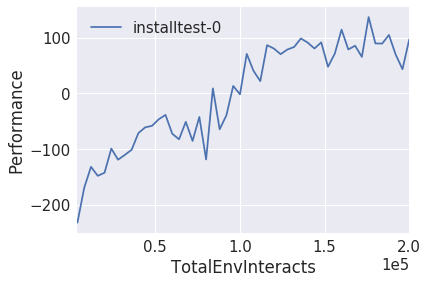

In [43]:
# main
make_plots(logdir, legends, xaxis, value, count,
          smooth=smooth, select=select, exclude=exclude, estimator=est)